In [14]:
import models
import utils
import data_processing
from constants import (
    VALUE_COLUMN,
    UNIT_RATE_COLUMN,
    QUANTITY_COLUMN,
    GROSS_WEIGHT_COLUMN,
    SHIP_COUNT_COLUMN,
    PORT_COUNT_COLUMN,
    FILL_METHOD,
    TARGET_COLUMN,
    VOLZA_COLUMNS,
    AIS_COLUMNS,
    OIL_COLUMNS,
    ARIMA_RESIDUAL_COLUMN,
    RANDOM_STATE
)
import pandas as pd
import constants
import sys
from datetime import datetime
from build_data import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
import numpy as np

In [15]:
COMMODITYS = ['cobalt', 'copper', 'germanium', 'magnesium', 'nickel']
target_COMMODITY = "cobalt"
WINDOW_SIZE = 20

In [16]:
pre_features = []
pre_labels = []
tar_features = []
tar_labels = []
# for COMMODITY in COMMODITYS:
COMMODITY = target_COMMODITY

VOLZA_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}.csv"
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"

# Get the data
data = get_data(VOLZA_FILE_PATH, PRICE_FILE_PATH, window_size=WINDOW_SIZE, center=False)

# Add Isolation Forest spikes column
data['spikes_if'] = utils.detect_spikes_if(data, TARGET_COLUMN + VOLZA_COLUMNS, contamination=0.1)

data['spikes_streaming'] = utils.detect_spikes_shift(data, 'Price', window_size=WINDOW_SIZE)

# Add Bowen's spike detection
spikes, features, labels = utils.detect_spikes_new(data, TARGET_COLUMN, window_size=WINDOW_SIZE, center=False)
if COMMODITY == target_COMMODITY:
    tar_features.extend(features)
    tar_labels.extend(labels)
    #     continue
    # pre_features.extend(features)
    # pre_labels.extend(labels)

data.head(2)

Building data...


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={"Value": "Brent Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={"Value": "WTI Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

Rows dropped due to NaN values: 1
Detecting spikes... 20


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if,spikes_streaming
1,2020-01-02,90209.765369,2300.0,0.0,39.903707,32355.0,67.05,61.17,32355.00000,0,0,0
2,2020-01-03,411.070686,10.0,0.0,41.107069,31850.0,69.08,63.00,-16915.55263,0,0,0


Spike Percentage: 19.98%


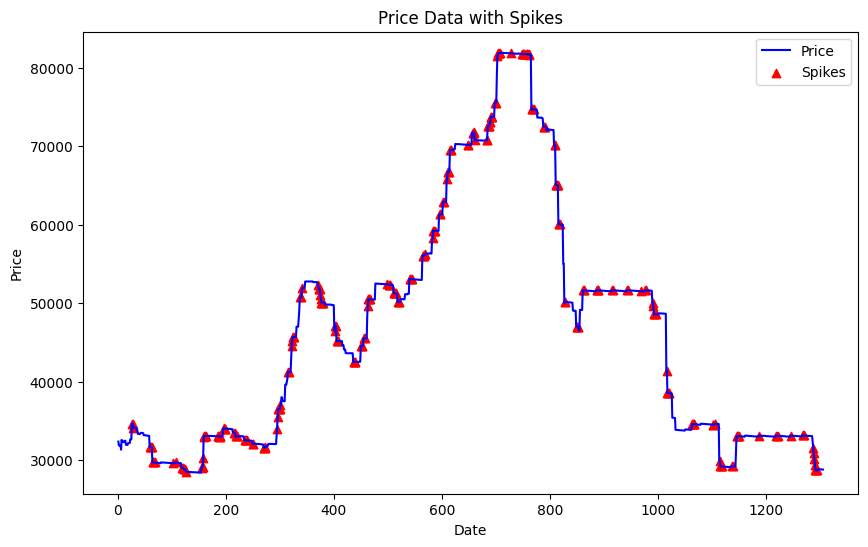

In [17]:
# padded_spikes = np.pad(spikes, (data.shape[0] - len(spikes), 0), 'constant', constant_values=(0,))
# data['spikes'] = padded_spikes
# utils.plot_prices(data,column='spikes')

In [18]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomOverSampler
output_file_path = f'{target_COMMODITY}_test/test/results_test.csv'
pred_file_path = f'{target_COMMODITY}_test/test/predictions/test'
model_path = f'{target_COMMODITY}_test/best_model'

In [19]:
data

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if,spikes_streaming
1,2020-01-02,90209.765369,2300.00,0.0,39.903707,32355.0,67.05,61.17,32355.000000,0,0,0
2,2020-01-03,411.070686,10.00,0.0,41.107069,31850.0,69.08,63.00,-16915.552630,0,0,0
3,2020-01-04,56374.663895,1000.00,0.0,56.374664,31850.0,69.08,63.00,-4594.232091,0,0,0
4,2020-01-05,40515.222453,1140.00,0.0,35.644705,31850.0,69.08,63.00,-2451.999062,0,0,0
5,2020-01-06,95421.681635,2290.00,342.8,37.417776,31834.0,70.25,63.27,-1892.944467,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1302,2023-12-25,89136.750000,3000.00,0.0,30.255888,28819.0,78.89,72.16,59817.499192,0,0,0
1303,2023-12-26,116051.470000,3000.00,0.0,38.338660,28819.0,78.89,72.16,60067.642449,0,0,0
1304,2023-12-27,56110.000000,1841.78,0.0,46.549676,28792.5,78.89,72.16,60291.285706,0,0,0
1305,2023-12-28,225606.070000,4446.50,0.0,76.015813,28787.5,78.89,72.16,60536.428962,0,0,0


In [20]:
aggregated_df = data
SPIKE_COLUMN = 'spikes_if'

In [21]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

aggregated_df['Price_binned'] = discretizer.fit_transform(aggregated_df[['Price']])
# aggregated_df['AR_binned'] = discretizer.fit_transform(aggregated_df[['ARIMA_Residuals']])
# aggregated_df['Value_binned'] = discretizer.fit_transform(aggregated_df[['Value']])


aggregated_df

c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if,spikes_streaming,Price_binned
1,2020-01-02,90209.765369,2300.00,0.0,39.903707,32355.0,67.05,61.17,32355.000000,0,0,0,0.0
2,2020-01-03,411.070686,10.00,0.0,41.107069,31850.0,69.08,63.00,-16915.552630,0,0,0,0.0
3,2020-01-04,56374.663895,1000.00,0.0,56.374664,31850.0,69.08,63.00,-4594.232091,0,0,0,0.0
4,2020-01-05,40515.222453,1140.00,0.0,35.644705,31850.0,69.08,63.00,-2451.999062,0,0,0,0.0
5,2020-01-06,95421.681635,2290.00,342.8,37.417776,31834.0,70.25,63.27,-1892.944467,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,2023-12-25,89136.750000,3000.00,0.0,30.255888,28819.0,78.89,72.16,59817.499192,0,0,0,0.0
1303,2023-12-26,116051.470000,3000.00,0.0,38.338660,28819.0,78.89,72.16,60067.642449,0,0,0,0.0
1304,2023-12-27,56110.000000,1841.78,0.0,46.549676,28792.5,78.89,72.16,60291.285706,0,0,0,0.0
1305,2023-12-28,225606.070000,4446.50,0.0,76.015813,28787.5,78.89,72.16,60536.428962,0,0,0,0.0


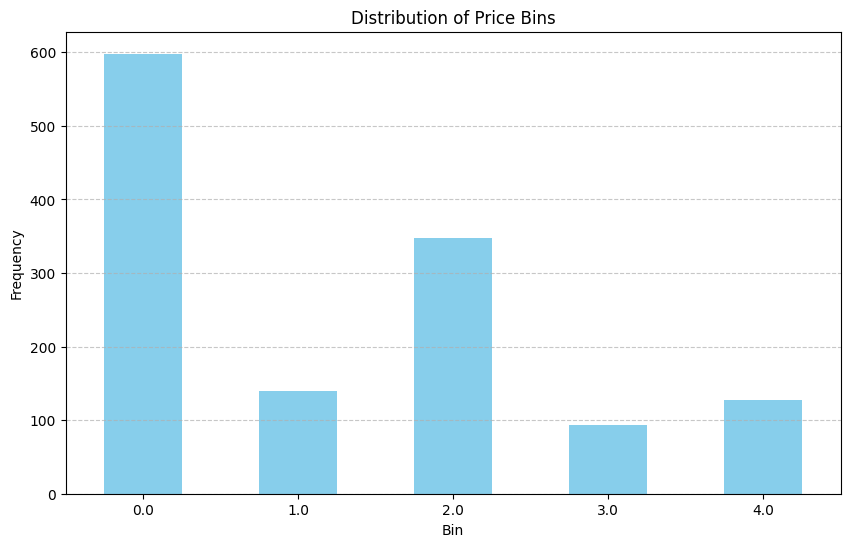

In [22]:
import matplotlib.pyplot as plt

# Assuming 'Price_binned' has been properly added to 'aggregated_df'
# Count the frequency of each bin
bin_counts = aggregated_df['Price_binned'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Price Bins')
plt.xlabel('Bin')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [23]:
# TARGET_COLUMN = ['Price_binned']

In [24]:
# X_price = np.array(tar_features)
# y_price = np.array(tar_labels)
X_price, y_price = data_processing.prepare_features_and_target(data, TARGET_COLUMN, 'spikes_streaming')


# Split price data
# X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.3, random_state=RANDOM_STATE, shuffle=False)
# X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(X_train_price, y_train_price, test_size=(10/70), random_state=RANDOM_STATE, shuffle=False)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.4, shuffle=False)
X_train_price, y_train_price = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train_price, y_train_price)

# Balancing
X_train_price, y_train_price = sampler(random_state=RANDOM_STATE).fit_resample(X_train_price, y_train_price)

# Scaling
# X_train_price, X_test_price, X_val_price = data_processing.scale_features(X_train_price, X_test_price, X_val_price)
X_train_price, X_test_price = data_processing.scale_features_no_val(X_train_price, X_test_price)

# Sequence making
X_train_price, y_train_price = data_processing.create_sequences(X_train_price, y_train_price, WINDOW_SIZE)
X_test_price, y_test_price = data_processing.create_sequences(X_test_price, y_test_price, WINDOW_SIZE)
#X_val_price, y_val_price = data_processing.create_sequences(X_val_price, y_val_price, WINDOW_SIZE)


# X_train_price = np.expand_dims(X_train_price, axis = 2)
# X_test_price = np.expand_dims(X_test_price, axis = 2)
# X_val_price = np.expand_dims(X_val_price, axis = 2)

In [25]:
# results_df  = models.evaluate_all(X_train_price, y_train_price, X_val_price, y_val_price, X_test_price, y_test_price, output_file_path, pred_file_path, model_path, False, edcra=False, val=True)
results_df  = models.evaluate_all(X_train_price, y_train_price, None, None, X_test_price, y_test_price, output_file_path, pred_file_path, model_path, False, edcra=False, val=False)



16/16 [==============================] - 0s 3ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/LSTM_256_layers_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/LSTM_256_layers_predictions.csv
{'Name': 'LSTM', 'Params': '256 layers', 'Accuracy': 0.15476190476190477, 'Precision (0)': 0.0, 'Recall (0)': 0.0, 'F1 (0)': 0.0, 'Precision (1)': 0.15476190476190477, 'Recall (1)': 1.0, 'F1 (1)': 0.2680412371134021, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

16/16 [==============================] - 0s 3ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/LSTM_128_layers_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/LSTM_128_layers_predictions.csv
{'Name': 'LSTM', 'Params': '128 layers', 'Accuracy': 0.8472222222222222, 'Precision (0)': 0.8483033932135728, 'Recall (0)': 0.9976525821596244, 'F1 (0)': 0.9169363538295576, 'Precision (1)': 0.6666666666666666, 'Recall (1)': 0.02564102564102564, 'F1 (1)': 0.04938271604938271, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 2ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/LSTM_64_layers_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/LSTM_64_layers_predictions.csv
{'Name': 'LSTM', 'Params': '64 layers', 'Accuracy': 0.15476190476190477, 'Precision (0)': 0.0, 'Recall (0)': 0.0, 'F1 (0)': 0.0, 'Precision (1)': 0.15476190476190477, 'Recall (1)': 1.0, 'F1 (1)': 0.2680412371134021, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

16/16 [==============================] - 0s 2ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/LSTM_32_layers_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/LSTM_32_layers_predictions.csv
{'Name': 'LSTM', 'Params': '32 layers', 'Accuracy': 0.8373015873015873, 'Precision (0)': 0.8453815261044176, 'Recall (0)': 0.9882629107981221, 'F1 (0)': 0.9112554112554112, 'Precision (1)': 0.16666666666666666, 'Recall (1)': 0.01282051282051282, 'F1 (1)': 0.023809523809523808, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_32_filters_7_kernels_predictions.csv
CNN_Attention_32_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 7', 'Accuracy': 0.8690476190476191, 'Precision (0)': 0.8829787234042553, 'Recall (0)': 0.9741784037558685, 'F1 (0)': 0.9263392857142858, 'Precision (1)': 0.6764705882352942, 'Recall (1)': 0.2948717948717949, 'F1 (1)': 0.4107142857142857, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 975us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_32_filters_5_kernels_predictions.csv
CNN_Attention_32_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 5', 'Accuracy': 0.9246031746031746, 'Precision (0)': 0.9369369369369369, 'Recall (0)': 0.9765258215962441, 'F1 (0)': 0.9563218390804598, 'Precision (1)': 0.8333333333333334, 'Recall (1)': 0.6410256410256411, 'F1 (1)': 0.7246376811594204, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 968us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_32_filters_3_kernels_predictions.csv
CNN_Attention_32_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 3', 'Accuracy': 0.876984126984127, 'Precision (0)': 0.8775933609958506, 'Recall (0)': 0.9929577464788732, 'F1 (0)': 0.9317180616740088, 'Precision (1)': 0.8636363636363636, 'Recall (1)': 0.24358974358974358, 'F1 (1)': 0.38000000000000006, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 2ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_64_filters_7_kernels_predictions.csv
CNN_Attention_64_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 7', 'Accuracy': 0.873015873015873, 'Precision (0)': 0.8724279835390947, 'Recall (0)': 0.9953051643192489, 'F1 (0)': 0.9298245614035088, 'Precision (1)': 0.8888888888888888, 'Recall (1)': 0.20512820512820512, 'F1 (1)': 0.3333333333333333, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_64_filters_5_kernels_predictions.csv
CNN_Attention_64_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 5', 'Accuracy': 0.8511904761904762, 'Precision (0)': 0.8559837728194726, 'Recall (0)': 0.9906103286384976, 'F1 (0)': 0.9183895538628944, 'Precision (1)': 0.6363636363636364, 'Recall (1)': 0.08974358974358974, 'F1 (1)': 0.15730337078651685, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 538us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_64_filters_3_kernels_predictions.csv
CNN_Attention_64_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 3', 'Accuracy': 0.8452380952380952, 'Precision (0)': 0.8452380952380952, 'Recall (0)': 1.0, 'F1 (0)': 0.9161290322580644, 'Precision (1)': 0.0, 'Recall (1)': 0.0, 'F1 (1)': 0.0, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

16/16 [==============================] - 0s 973us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_128_filters_7_kernels_predictions.csv
CNN_Attention_128_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 7', 'Accuracy': 0.8650793650793651, 'Precision (0)': 0.8683127572016461, 'Recall (0)': 0.9906103286384976, 'F1 (0)': 0.9254385964912282, 'Precision (1)': 0.7777777777777778, 'Recall (1)': 0.1794871794871795, 'F1 (1)': 0.29166666666666663, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_128_filters_5_kernels_predictions.csv
CNN_Attention_128_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 5', 'Accuracy': 0.878968253968254, 'Precision (0)': 0.8858350951374208, 'Recall (0)': 0.9835680751173709, 'F1 (0)': 0.9321468298109009, 'Precision (1)': 0.7741935483870968, 'Recall (1)': 0.3076923076923077, 'F1 (1)': 0.44036697247706424, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_128_filters_3_kernels_predictions.csv
CNN_Attention_128_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 3', 'Accuracy': 0.873015873015873, 'Precision (0)': 0.8786610878661087, 'Recall (0)': 0.9859154929577465, 'F1 (0)': 0.9292035398230087, 'Precision (1)': 0.7692307692307693, 'Recall (1)': 0.2564102564102564, 'F1 (1)': 0.38461538461538464, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_256_filters_7_kernels_predictions.csv
CNN_Attention_256_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 7', 'Accuracy': 0.8412698412698413, 'Precision (0)': 0.8574380165289256, 'Recall (0)': 0.9741784037558685, 'F1 (0)': 0.9120879120879122, 'Precision (1)': 0.45, 'Recall (1)': 0.11538461538461539, 'F1 (1)': 0.1836734693877551, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_256_filters_5_kernels_predictions.csv
CNN_Attention_256_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 5', 'Accuracy': 0.8511904761904762, 'Precision (0)': 0.8517034068136272, 'Recall (0)': 0.9976525821596244, 'F1 (0)': 0.918918918918919, 'Precision (1)': 0.8, 'Recall (1)': 0.05128205128205128, 'F1 (1)': 0.09638554216867469, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_Attention_256_filters_3_kernels_predictions.csv
CNN_Attention_256_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 3', 'Accuracy': 0.8690476190476191, 'Precision (0)': 0.8688524590163934, 'Recall (0)': 0.9953051643192489, 'F1 (0)': 0.9277899343544858, 'Precision (1)': 0.875, 'Recall (1)': 0.1794871794871795, 'F1 (1)': 0.2978723404255319, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/RNN_256_units_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/RNN_256_units_predictions.csv
RNN_256_units: {'Name': 'RNN', 'Params': '256 units', 'Accuracy': 0.15476190476190477, 'Precision (0)': 0.0, 'Recall (0)': 0.0, 'F1 (0)': 0.0, 'Precision (1)': 0.15476190476190477, 'Recall (1)': 1.0, 'F1 (1)': 0.2680412371134021, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

16/16 [==============================] - 0s 856us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/RNN_128_units_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/RNN_128_units_predictions.csv
RNN_128_units: {'Name': 'RNN', 'Params': '128 units', 'Accuracy': 0.8412698412698413, 'Precision (0)': 0.8530612244897959, 'Recall (0)': 0.9812206572769953, 'F1 (0)': 0.9126637554585152, 'Precision (1)': 0.42857142857142855, 'Recall (1)': 0.07692307692307693, 'F1 (1)': 0.13043478260869565, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 867us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/RNN_64_units_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/RNN_64_units_predictions.csv
RNN_64_units: {'Name': 'RNN', 'Params': '64 units', 'Accuracy': 0.15476190476190477, 'Precision (0)': 0.0, 'Recall (0)': 0.0, 'F1 (0)': 0.0, 'Precision (1)': 0.15476190476190477, 'Recall (1)': 1.0, 'F1 (1)': 0.2680412371134021, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

16/16 [==============================] - 0s 740us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/RNN_32_units_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/RNN_32_units_predictions.csv
RNN_32_units: {'Name': 'RNN', 'Params': '32 units', 'Accuracy': 0.8531746031746031, 'Precision (0)': 0.8548387096774194, 'Recall (0)': 0.9953051643192489, 'F1 (0)': 0.9197396963123645, 'Precision (1)': 0.75, 'Recall (1)': 0.07692307692307693, 'F1 (1)': 0.13953488372093026, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 631us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_32_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_32_filters_7_kernels_predictions.csv
CNN_32_filters_7_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 7', 'Accuracy': 0.8809523809523809, 'Precision (0)': 0.8893617021276595, 'Recall (0)': 0.9812206572769953, 'F1 (0)': 0.9330357142857143, 'Precision (1)': 0.7647058823529411, 'Recall (1)': 0.3333333333333333, 'F1 (1)': 0.4642857142857143, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 621us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_32_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_32_filters_5_kernels_predictions.csv
CNN_32_filters_5_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 5', 'Accuracy': 0.9087301587301587, 'Precision (0)': 0.9337899543378996, 'Recall (0)': 0.960093896713615, 'F1 (0)': 0.9467592592592593, 'Precision (1)': 0.7424242424242424, 'Recall (1)': 0.6282051282051282, 'F1 (1)': 0.6805555555555556, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 673us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_32_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_32_filters_3_kernels_predictions.csv
CNN_32_filters_3_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 3', 'Accuracy': 0.9087301587301587, 'Precision (0)': 0.9357798165137615, 'Recall (0)': 0.9577464788732394, 'F1 (0)': 0.9466357308584686, 'Precision (1)': 0.7352941176470589, 'Recall (1)': 0.6410256410256411, 'F1 (1)': 0.6849315068493151, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 748us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_64_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_64_filters_7_kernels_predictions.csv
CNN_64_filters_7_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 7', 'Accuracy': 0.9126984126984127, 'Precision (0)': 0.9321266968325792, 'Recall (0)': 0.9671361502347418, 'F1 (0)': 0.9493087557603687, 'Precision (1)': 0.7741935483870968, 'Recall (1)': 0.6153846153846154, 'F1 (1)': 0.6857142857142857, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 740us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_64_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_64_filters_5_kernels_predictions.csv
CNN_64_filters_5_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 5', 'Accuracy': 0.9166666666666666, 'Precision (0)': 0.9363636363636364, 'Recall (0)': 0.9671361502347418, 'F1 (0)': 0.9515011547344111, 'Precision (1)': 0.78125, 'Recall (1)': 0.6410256410256411, 'F1 (1)': 0.7042253521126761, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 229us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_64_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_64_filters_3_kernels_predictions.csv
CNN_64_filters_3_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 3', 'Accuracy': 0.9226190476190477, 'Precision (0)': 0.9367945823927766, 'Recall (0)': 0.9741784037558685, 'F1 (0)': 0.9551208285385501, 'Precision (1)': 0.819672131147541, 'Recall (1)': 0.6410256410256411, 'F1 (1)': 0.7194244604316549, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 991us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_128_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_128_filters_7_kernels_predictions.csv
CNN_128_filters_7_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 7', 'Accuracy': 0.9067460317460317, 'Precision (0)': 0.9220489977728286, 'Recall (0)': 0.971830985915493, 'F1 (0)': 0.9462857142857143, 'Precision (1)': 0.7818181818181819, 'Recall (1)': 0.5512820512820513, 'F1 (1)': 0.6466165413533834, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_128_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_128_filters_5_kernels_predictions.csv
CNN_128_filters_5_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 5', 'Accuracy': 0.9166666666666666, 'Precision (0)': 0.9324324324324325, 'Recall (0)': 0.971830985915493, 'F1 (0)': 0.9517241379310345, 'Precision (1)': 0.8, 'Recall (1)': 0.6153846153846154, 'F1 (1)': 0.6956521739130435, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 962us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_128_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_128_filters_3_kernels_predictions.csv
CNN_128_filters_3_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 3', 'Accuracy': 0.9285714285714286, 'Precision (0)': 0.9372197309417041, 'Recall (0)': 0.9812206572769953, 'F1 (0)': 0.9587155963302753, 'Precision (1)': 0.8620689655172413, 'Recall (1)': 0.6410256410256411, 'F1 (1)': 0.7352941176470588, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_256_filters_7_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_256_filters_7_kernels_predictions.csv
CNN_256_filters_7_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 7', 'Accuracy': 0.9146825396825397, 'Precision (0)': 0.9322799097065463, 'Recall (0)': 0.9694835680751174, 'F1 (0)': 0.950517836593786, 'Precision (1)': 0.7868852459016393, 'Recall (1)': 0.6153846153846154, 'F1 (1)': 0.6906474820143885, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 972us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_256_filters_5_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_256_filters_5_kernels_predictions.csv
CNN_256_filters_5_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 5', 'Accuracy': 0.8888888888888888, 'Precision (0)': 0.8952991452991453, 'Recall (0)': 0.9835680751173709, 'F1 (0)': 0.9373601789709173, 'Precision (1)': 0.8055555555555556, 'Recall (1)': 0.3717948717948718, 'F1 (1)': 0.5087719298245614, 'Prior': '0.15'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 955us/step
Predictions saved to CSV file: cobalt_test/test/predictions/test/CNN_256_filters_3_kernels_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test_confidence/CNN_256_filters_3_kernels_predictions.csv
CNN_256_filters_3_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 3', 'Accuracy': 0.9345238095238095, 'Precision (0)': 0.9517241379310345, 'Recall (0)': 0.971830985915493, 'F1 (0)': 0.9616724738675958, 'Precision (1)': 0.8260869565217391, 'Recall (1)': 0.7307692307692307, 'F1 (1)': 0.7755102040816326, 'Prior': '0.15'}
Predictions saved to CSV file: cobalt_test/test/predictions/test/Dumb_Model_spikes_predictions.csv
Predictions saved to CSV file: cobalt_test/test/predictions/test/Dumb_Model_non_spikes_predictions.csv


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [26]:
results_df.head(33)

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Prior
0,LSTM,256 layers,0.154762,0.000000,0.000000,0.000000,0.154762,1.000000,0.268041,0.15
1,LSTM,128 layers,0.847222,0.848303,0.997653,0.916936,0.666667,0.025641,0.049383,0.15
2,LSTM,64 layers,0.154762,0.000000,0.000000,0.000000,0.154762,1.000000,0.268041,0.15
3,LSTM,32 layers,0.837302,0.845382,0.988263,0.911255,0.166667,0.012821,0.023810,0.15
4,CNN with Attention,"32 filters, kernel size 7",0.869048,0.882979,0.974178,0.926339,0.676471,0.294872,0.410714,0.15
5,CNN with Attention,"32 filters, kernel size 5",0.924603,0.936937,0.976526,0.956322,0.833333,0.641026,0.724638,0.15
6,CNN with Attention,"32 filters, kernel size 3",0.876984,0.877593,0.992958,0.931718,0.863636,0.243590,0.380000,0.15
7,CNN with Attention,"64 filters, kernel size 7",0.873016,0.872428,0.995305,0.929825,0.888889,0.205128,0.333333,0.15
8,CNN with Attention,"64 filters, kernel size 5",0.851190,0.855984,0.990610,0.918390,0.636364,0.089744,0.157303,0.15
9,CNN with Attention,"64 filters, kernel size 3",0.845238,0.845238,1.000000,0.916129,0.000000,0.000000,0.000000,0.15
